In [1]:
#%load_ext autoreload
#%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import psycopg2
import psycopg2.extras

In [2]:
# Initialise connection

with open('../.streamlit/secrets.toml', 'r') as file:
    lines = file.readlines()

# Remove the header line ([postgres])
lines = lines[1:]

config_dict = {}
# Put the parameters in a dict
for line in lines:
    key, value = line.strip().split(' = ')
    value = value.strip('"')
    config_dict[key] = value

# Create a DB connection
conn = psycopg2.connect(
    database=config_dict['dbname'],
    user=config_dict['user'],
    password=config_dict['password'],
    host=config_dict['host'],
    port=config_dict['port'],
)
cursor = conn.cursor()

In [3]:
# Test connection

test_q = "SELECT * FROM sitemap_table LIMIT 3;"
cursor.execute("ROLLBACK")
cursor.execute(test_q)

results = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(results, columns=columns)

print(df)


  publication_name                                         news_title  \
0        l'Opinion  Alexandre Saubot abandonne la course à l'élect...   
1        l'Opinion  Trop d'impôt tue l'impôt... mais à partir de c...   
2        l'Opinion  L'élection partielle en Ariège ravive l'opposi...   

  download_date news_publication_date  \
0    2023-04-13            2023-03-27   
1    2023-04-13            2023-03-27   
2    2023-04-13            2023-03-27   

                                       news_keywords    section  \
0                         Medef, patronat, industrie   economie   
1  capital, imposition, coût du travail, Arthur L...   economie   
2  élections législatives partielles, La France i...  politique   

           image_caption media_type  
0      Alexandre Saubot.   webpress  
1  Photo d'illustration.   webpress  
2     Bénédicte Taurine.   webpress  


In [4]:
# Pull historical stats about the number of daily articles loaded

stats_q = """
SELECT 
    download_date,
    media_type,
    publication_name,
    COUNT(1) AS articles,
    COUNT(news_title) AS title,
    COUNT(news_publication_date) AS publication_date,
    COUNT(news_keywords) AS keywords,
    COUNT(section) AS section,
    COUNT(image_caption) AS caption
FROM sitemap_table 
GROUP BY 1,2,3;
"""
cursor.execute("ROLLBACK")
cursor.execute(stats_q)

stats_raw = cursor.fetchall()
stats_columns = [desc[0] for desc in cursor.description]
stats = pd.DataFrame(stats_raw, columns= stats_columns)

# Set datetime format and create "is_Mon_Tue" column
stats['download_date'] = pd.to_datetime(stats['download_date'])
stats['is_Mon_Tue'] = stats['download_date'].dt.weekday.isin([0, 1])

print(stats)

     download_date media_type         publication_name  articles  title  \
0       2023-01-20   webpress             20minutes.fr       199    199   
1       2022-12-14   webpress                L'Express        29     29   
2       2023-04-19   webpress                 Le Monde       208    208   
3       2023-01-14   webpress                 Le Monde       119    119   
4       2022-12-10   webpress             20minutes.fr       194    194   
...            ...        ...                      ...       ...    ...   
1796    2023-05-13   webpress              L'Équipe.fr        59     59   
1797    2023-04-23   webpress                 Le Monde       202    202   
1798    2022-12-22   webpress                L'Express        64     64   
1799    2023-01-20   webpress               Libération        71     71   
1800    2023-04-29   webpress  Journal La Marseillaise        70     70   

      publication_date  keywords  section  caption  is_Mon_Tue  
0                  199         0  

In [5]:
aggregations = {
    'articles': 'sum',
    'download_date': 'min',
    'title' : 'sum',
    'publication_date' : 'sum',
    'keywords' : 'sum',
    'section' : 'sum',
    'caption' : 'sum'
}

share_metrics = ['title', 'publication_date', 'keywords', 'section', 'caption']

def compute_share_metric(column_num, df, column_denom = 'articles'):
    df[column_num] = (100.0 * df[column_num] / df[column_denom]).round(1)

## Create new column names
col_names_agg = []
for key in aggregations:
    name = f"share_{key}"
    col_names_agg.append(name)

## Agregate and compute ratio metrics
publication_agg = stats.groupby('publication_name').agg(aggregations)
for col in share_metrics:
    compute_share_metric(col, publication_agg)

## Clean up col names
publication_agg.columns = col_names_agg
publication_agg = publication_agg.rename(columns = {
    'share_download_date' : 'first_download',
    'share_articles': 'tot_articles'})

publication_agg.sort_values('tot_articles', ascending=False)

,tot_articles,first_download,share_title,share_publication_date,share_keywords,share_section,share_caption
publication_name,,,,,,,
NaN,223366,2023-04-29,100.0,100.0,100.0,100.0,100.0
Le Télégramme,141411,2023-01-16,100.0,100.0,95.7,100.0,91.4
BFMTV,74491,2022-11-27,100.0,100.0,67.3,100.0,100.0
Le Figaro,62685,2022-11-27,100.0,100.0,99.8,100.0,98.2
Franceinfo,34843,2022-11-27,100.0,100.0,99.2,100.0,97.3
20minutes.fr,34595,2022-11-27,100.0,100.0,70.4,100.0,98.4
l'Opinion,32104,2023-01-17,100.0,100.0,99.5,100.0,98.1
BFM Business,24110,2022-11-27,100.0,100.0,65.6,100.0,100.0
Le Monde,21314,2022-11-27,100.0,100.0,68.4,100.0,90.1


## Analyses par publication (Tab 1)
* Gros volume d'articles sans publication_name
* Les champs sont remplis la plupart du temps pour la majorite des publication. 
    * Exception 1: Keywords souvent absent sur BFMTV, 20Minutes, BFM Business, Le Monde, Le Point (0%), l'Express, L'obs (0%)
    * Exception 2: Moins de 90% de Captions pour Le Monde, Les Echos, Le Point (61%), l'Express



In [7]:
## Create a distinct media_type to collect the entries with NaN as publication_name

stats.loc[stats['publication_name'] == 'NaN', 'media_type']= 'NaN'

aggregations = {
    'articles': 'sum',
    'keywords' : 'sum',
    'caption' : 'sum'
}

share_metrics = ['keywords', 'caption']

## Create new column names
col_names_agg = []
for key in aggregations:
    name = f"share_{key}"
    col_names_agg.append(name)

## Agregate and compute ratio metrics
daily_type_agg = stats.groupby(['media_type', 'download_date']).agg(aggregations)
for col in share_metrics:
    compute_share_metric(col, daily_type_agg)

## Clean up col names
daily_type_agg.columns = col_names_agg
daily_type_agg = daily_type_agg.rename(columns = {
    'share_articles': 'tot_articles'})

daily_type_agg.sort_values('tot_articles', ascending=False)

tot_articles  share_keywords  share_caption
media_type download_date                                             
NaN        2023-05-18             7095           100.0          100.0
           2023-05-17             7015           100.0          100.0
           2023-05-19             6987           100.0          100.0
           2023-05-28             6954           100.0          100.0
           2023-05-27             6898           100.0          100.0
...                                ...             ...            ...
webpress   2022-12-26              301            35.2           86.0
           2022-12-25              297            32.3           84.2
tv         2023-01-02              271            37.3           99.6
           2022-12-26              265            32.5           99.6
           2023-03-20              234           100.0           96.2

[335 rows x 3 columns]

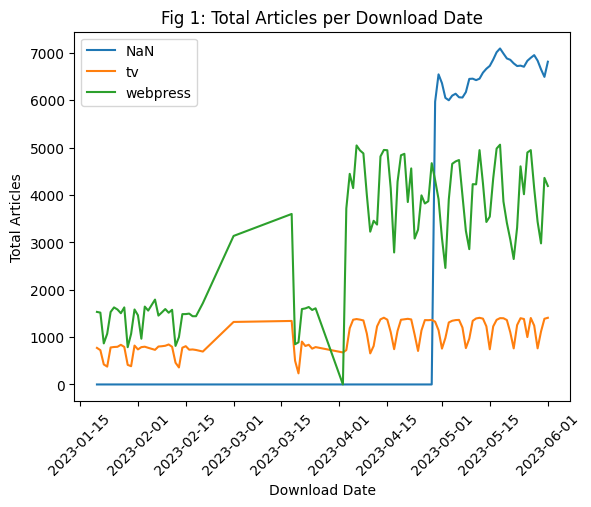

In [8]:
## Analysis of historical volumes per media_type

# Get unique media_type values
unique_type = daily_type_agg.index.get_level_values('media_type').unique()

# Get all the date values and sort them
index = daily_type_agg.index.get_level_values('download_date').unique()
index = index.sort_values()
# Keep the last N values: 
index_last_X= index[-100:]

# Filter the data per media_type, reindex, and plot it
for mtype in unique_type:
    var_name = f'data_{mtype}'
    filtered_data = daily_type_agg.loc[mtype]
    filtered_data = filtered_data[filtered_data.index.get_level_values('download_date').isin(index_last_X)]
    globals()[var_name] = filtered_data.reindex(index_last_X).fillna(0)
    plt.plot(globals()[var_name].index, globals()[var_name]['tot_articles'], label=mtype)

plt.xlabel('Download Date')
plt.ylabel('Total Articles')
plt.title('Fig 1: Total Articles per Download Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Analyse temporelle (Fig 1)
* Volume stable pour la TV et Webpress depuis le début d'avril 2023.
* Un volume additionnel de NaN apparaît à partir du début de mai 2023.
* Contrairement aux séries Webpress et TV, son volume ne suit pas les périodicités hebdomadaires (élevé en semaine, bas le week-end) des autres séries.

> Se pourrait-il que ces NaN correspondent a  des articles "bloqués" en ingestion ?

In [ ]:
## Zoom on Publcation Name = NaN

nan_q = """
SELECT 
    news_title, 
    news_keywords,
    section,
    media_type,
    COUNT(1) as entries
FROM sitemap_table 
WHERE publication_name = 'NaN' 
GROUP BY 1,2,3,4
ORDER BY 5 DESC
LIMIT 10;"""
cursor.execute("ROLLBACK")
cursor.execute(nan_q)

results_nan = cursor.fetchall()
columns_nan = [desc[0] for desc in cursor.description]
data_nan = pd.DataFrame(results_nan, columns=columns_nan)

print(data_nan)

## Inspection des lignes "NaN"
Toutes les valeurs sont NaN, impossible d'en deduire quoi que ce soit, si ce n'est le champs "section" qui semble indiquer qu'il s'agit d'une valeur par defaut.

In [9]:
## Creating alerting thresholds for extreme values

# Reset the index and create the is_Mon_Tue field for daily_type_agg
daily_type_agg.reset_index(inplace=True)
daily_type_agg.loc[:, 'is_Mon_Tue'] = daily_type_agg['download_date'].dt.weekday.isin([0,1])


# Only keep values since the latest uptick in daily volumes:
filtered_stats = stats[
    stats['download_date'] > pd.to_datetime(datetime(2023, 4, 1))]
filtered_media_stats = daily_type_agg[
    daily_type_agg['download_date'] > pd.to_datetime(datetime(2023, 4, 1))]

# Remove the latest data point to not contaminate the dispersion metrics with potential outliers to detect
filtered_stats = filtered_stats[
    filtered_stats['download_date'] < filtered_stats['download_date'].max()
]
filtered_media_stats = filtered_media_stats[
    filtered_media_stats['download_date'] < filtered_media_stats['download_date'].max()
].copy()


# Get dispersion stats by media and publication:
publication_thresholds = filtered_stats.groupby([
    'publication_name', 'is_Mon_Tue'
])['articles'].agg([
    'min',
    lambda x: x.quantile(0.05),
    'median',
    lambda x: x.quantile(0.95),
    'max'
])
media_thresholds = filtered_media_stats.groupby([
    'media_type', 'is_Mon_Tue'
])['tot_articles'].agg([
    'min',
    lambda x: x.quantile(0.05),
    'median',
    lambda x: x.quantile(0.95),
    'max'
])

## Set clean names of columns
col_names = ['min_articles', 'p05_articles', 'median_articles', 'p95_articles', 'max_articles']
media_thresholds.columns = col_names
publication_thresholds.columns = col_names

# Print the resulting statistics
#print(publication_thresholds)
#print(media_thresholds)

## Definition of the alerting thresholds:
# Alert sent if the daily amount of articles loaded is below half of the 5th percentile 
# If the publication is so small that the alerting threshold would be below 15, no alert is set
# This is a very coarse criteria design to limit false alerts, can be adjusted in the future

publication_thresholds['threshold'] = np.where(
    publication_thresholds['p05_articles'] / 2 < 15, 
    0, 
    publication_thresholds['p05_articles'] / 2
)
media_thresholds['threshold'] = np.where(
    media_thresholds['p05_articles'] / 2 < 15, 
    0, 
    media_thresholds['p05_articles'] / 2
)

In [10]:
daily_type_agg

,media_type,download_date,tot_articles,share_keywords,share_caption,is_Mon_Tue
0,NaN,2023-04-29,5971,100.0,100.0,False
1,NaN,2023-04-30,6548,100.0,100.0,False
2,NaN,2023-05-01,6362,100.0,100.0,True
3,NaN,2023-05-02,6052,100.0,100.0,True
4,NaN,2023-05-03,6001,100.0,100.0,False
...,...,...,...,...,...,...
330,webpress,2023-05-28,4141,100.0,100.0,False
331,webpress,2023-05-29,3434,100.0,100.0,True
332,webpress,2023-05-30,2979,100.0,100.0,True
333,webpress,2023-05-31,4362,100.0,100.0,False


In [13]:
## Detection of the values below the threshold

# Merging the threshold with the daily stats
detection_media = pd.merge(daily_type_agg, media_thresholds, on=['media_type', 'is_Mon_Tue'], how='left')
detection = pd.merge(stats, publication_thresholds, on=['publication_name', 'is_Mon_Tue'], how='left')

alerts_media = detection_media[
    detection_media['tot_articles'] < detection_media['threshold']
].sort_values(['download_date'])
alert_publication = detection[
    detection['articles'] < detection['threshold']
].sort_values(['download_date'])

if len(alerts_media) > 0:
    print("Alerts at media_type level")
    print(alerts_media)
else:
    print("Alerts at publication level")
    print(alert_publication)


Alerts at media_type level
    media_type download_date  tot_articles  share_keywords  share_caption  \
185   webpress    2022-11-27          1380            41.4           80.1   
187   webpress    2022-12-01           913            41.2           82.5   
188   webpress    2022-12-03           937            39.8           82.8   
189   webpress    2022-12-04           489            37.2           78.1   
38          tv    2022-12-04           393            33.6          100.0   
..         ...           ...           ...             ...            ...   
118         tv    2023-03-20           234           100.0           96.2   
271   webpress    2023-03-22          1606            89.8           97.6   
272   webpress    2023-03-23          1635            90.6           96.8   
273   webpress    2023-03-24          1573            90.3           96.1   
274   webpress    2023-03-25          1608            89.7           96.4   

     is_Mon_Tue  min_articles  p05_articles  med

In [ ]:
# daily_type_agg.to_csv('daily_type_agg.csv', index=False)